### Import libraries and get data

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pmd

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.arima.model import ARIMA

## Load the dataset

In [42]:
# Load the dataset
df = pd.read_csv("./USDT.csv")

# Drop the unnecessary columns.
df.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1, inplace=True)

# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
                                    
# Sort the DataFrame by date
df = df.sort_values('Date')

# Set Date index
df.set_index('Date', inplace=True)

df

,Price
Date,
2017-12-01,1.0100
2017-12-02,0.9959
2017-12-03,0.9977
2017-12-04,1.0000
2017-12-05,1.0000
...,...
2023-03-28,1.0001
2023-03-29,0.9999
2023-03-30,1.0000


### Split the data into training, test and validate sets

In [43]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1362, 1)
Test shape: (389, 1)
Validate shape: (196, 1)


In [ ]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

In [ ]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

## ARIMA Model

### 3. Perfom ARIMA Model 

In [44]:
!pip install pmdarima

In [45]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

### 3.1 Build the best ARIMA Model using p,d,q from auto_arima

In [46]:
arima_model = pmd.auto_arima(y_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=False,
                         d=None, D=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic


C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-11684.760, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3868.101, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.98 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-11723.739, Time=0.38 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-11721.681, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-11723.605, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-11721.615, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-11756.317, Time=0.41 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-11102.504, Time=1.49 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-11738.216, Time=0.48 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-11748.509, Time=1.31 sec
 ARIMA(1,0,3)(0,0

In [47]:
order = (arima_model.order[0], arima_model.order[1], arima_model.order[2])
print(order)

(1, 0, 2)


In [48]:
def evaluate_ariama_model(x_data, y_data, order):
    y_preds = list()
    for t in range(len(y_data)):
        model = ARIMA(y_train, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        y_preds.append(yhat)
    mse = mean_squared_error(y_data, y_preds)
    mae = mean_absolute_error(y_data, y_preds)
    mape = mean_absolute_percentage_error(y_data, y_preds)
    rmse = mean_squared_error(y_data, y_preds, squared=False)
    return y_preds, mse, mae, mape, rmse

### 3.2 Evaluate on Validate data

In [49]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val, val_mse, val_mae, val_mape, val_rmse = evaluate_ariama_model(x_val, y_val, order)

print("Price predict on validate data:", y_pred_val)

Price predict on validate data: [1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205

### 3.3 Evaluate on Test data

In [50]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred_test, test_mse, test_mae, test_mape, test_rmse = evaluate_ariama_model(x_test, y_test, order)

print("Price predict on test data:", y_pred_test)

Price predict on test data: [1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.000345149431205, 1.

### 3.4 Predict price for the next 30 days

In [51]:
last_index = len(df)

date_range = pd.date_range(start=df.index[-1], periods=30, freq='D')

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = arima_model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1.00033935 1.00034279 1.00034079 1.00033895 1.00033726 1.00033571
 1.00033429 1.00033299 1.00033179 1.00033069 1.00032968 1.00032876
 1.00032791 1.00032713 1.00032642 1.00032576 1.00032516 1.0003246
 1.0003241  1.00032363 1.00032321 1.00032281 1.00032245 1.00032213
 1.00032182 1.00032154 1.00032129 1.00032106 1.00032084 1.00032064]


### 4.  Evaluate accuracy validate, test data

In [52]:
metrics = {
    'MSE': [val_mse, test_mse],
    'MAE': [val_mae, test_mae],
    'MAPE': [val_mape, test_mape],
    'RMSE': [val_rmse, test_rmse],
}

acc = pd.DataFrame(metrics, index=['Validate', 'Test'])

print(acc)

                   MSE       MAE      MAPE      RMSE
Validate  9.892179e-07  0.000545  0.000545  0.000995
Test      3.208393e-07  0.000382  0.000382  0.000566


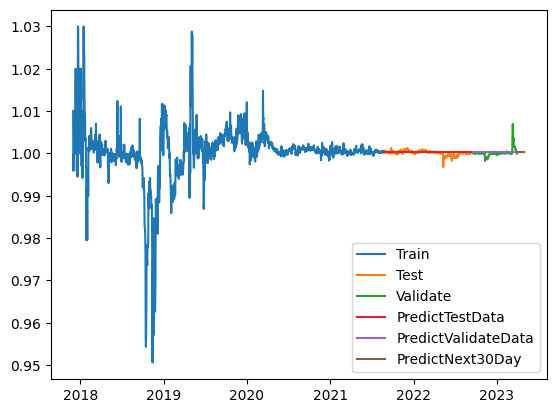

In [53]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])

plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(date_range, y_next_30_days)

plt.legend(['Train', 'Test', 'Validate','PredictTestData', 'PredictValidateData','PredictNext30Day'])
plt.show()